In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pymssql
# import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
import seaborn as sns

2022-12-13 15:03:20.208982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 15:03:20.209032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
def get_data():
    df=pd.DataFrame()
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to make connection',e)
    cur=con.cursor()

    query = """IF OBJECT_ID('TEMPDB..#CLAIMS') IS NOT NULL
DROP TABLE #CLAIMS
SELECT CONVERT(DATE,C.DOS) AS DOS,CLAIM_NO INTO #CLAIMS FROM CLAIMS AS C
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(C.DELETED,0)=0 AND CONVERT(DATE,C.DOS) BETWEEN '01-01-2020' AND '12-10-2022'----6383824



---------------------------#CHARGES----------------------
IF OBJECT_ID('TEMPDB..#CHARGES') IS NOT NULL
DROP TABLE #CHARGES
SELECT C.Claim_No,CC.claim_charges_id,CC.Amount INTO #CHARGES FROM Claim_Charges AS CC
JOIN #CLAIMS AS C ON CC.Claim_No=C.Claim_No
WHERE ISNULL(CC.DELETED,0)=0------



---------------------------------------------------------
SELECT CONVERT(DATE,C.DOS)AS DOS,COUNT(DISTINCT C.Claim_No) AS CLAIM_COUNT,SUM(CC.Amount) AS CHARGES_SUM FROM #CLAIMS AS C LEFT JOIN #CHARGES AS CC
ON C.Claim_No=CC.Claim_No
GROUP BY CONVERT(DATE,C.DOS)
ORDER BY CONVERT(DATE,C.DOS) ASC;
        """
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
#         print(df)
#         df.columns=df.columns.str.upper()
        con.close()
    except:
        print('Error in reading data.....')
        con.close()
    return df

In [12]:
df = get_data()

In [13]:
df.isna().sum()

DOS            0
CLAIM_COUNT    0
CHARGES_SUM    0
dtype: int64

In [14]:
df.head()

,DOS,CLAIM_COUNT,CHARGES_SUM
0,2020-01-01,3279,962075.9100
1,2020-01-02,15600,4003143.5500
2,2020-01-03,14293,3504451.8400
3,2020-01-04,3593,896097.0200
4,2020-01-05,2046,501255.8500


In [15]:
df["DOS"] = pd.to_datetime(df["DOS"])

In [16]:
charges_data = df[["DOS", "CHARGES_SUM"]]

In [17]:
charges_data = charges_data.set_index('DOS')

In [18]:
len(charges_data)

1075

In [19]:
charges_data.CHARGES_SUM = charges_data.CHARGES_SUM.apply(int)

In [20]:
charges_data.head()

,CHARGES_SUM
DOS,
2020-01-01,962075
2020-01-02,4003143
2020-01-03,3504451
2020-01-04,896097
2020-01-05,501255


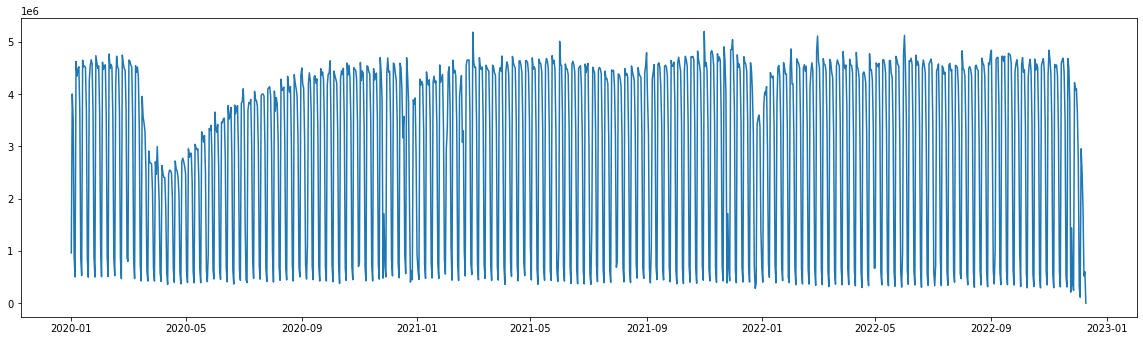

In [21]:
plt.rcParams["figure.figsize"] = (20,5.5)

plt.plot(charges_data)

plt.show()

In [22]:
train = charges_data.loc[:'2022-08-31']
len(train)
# train.head()
test = charges_data.loc['2022-09-01':]
# len(test)
# test.tail()
# train_dates = pd.to_datetime(train['Date'])
# test_dates  = pd.to_datetime(test['Date'])

In [23]:
len(train), len(test)

(974, 101)

In [24]:
train.shape

(974, 1)

In [25]:
train.head()

,CHARGES_SUM
DOS,
2020-01-01,962075
2020-01-02,4003143
2020-01-03,3504451
2020-01-04,896097
2020-01-05,501255


In [26]:
# train_dates = pd.to_datetime(train['DOS'])
# test_dates  = pd.to_datetime(test['DOS'])

### Prepare Data

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['CHARGES_SUM'].values.reshape(-1,1))
prediction_days = 145

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
# x_train

### Build The Model 

In [29]:
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

2022-12-13 15:07:02.704083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 15:07:02.704262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-13 15:07:02.704437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-13 15:07:02.704594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-13 15:07:02.704723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(x_train, y_train, epochs = 220, batch_size=32, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 145, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 145, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 145, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 145, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

24/24 [==============================] - 14s 586ms/step - loss: 0.0117 - val_loss: 0.0080
Epoch 147/220
24/24 [==============================] - 14s 593ms/step - loss: 0.0102 - val_loss: 0.0076
Epoch 148/220
24/24 [==============================] - 14s 592ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 149/220
24/24 [==============================] - 14s 586ms/step - loss: 0.0114 - val_loss: 0.0089
Epoch 150/220
24/24 [==============================] - 14s 570ms/step - loss: 0.0109 - val_loss: 0.0091
Epoch 151/220
24/24 [==============================] - 14s 572ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 152/220
24/24 [==============================] - 14s 578ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 153/220
24/24 [==============================] - 14s 573ms/step - loss: 0.0109 - val_loss: 0.0078
Epoch 154/220
24/24 [==============================] - 14s 583ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 155/220
24/24 [==============================] - 14s 586ms/step - loss: 

### Prediction

In [31]:
# y_train

In [32]:
actual_temp = test['CHARGES_SUM'].values
total_temp = pd.concat((train['CHARGES_SUM'], test['CHARGES_SUM']),axis=0)

model_inputs = total_temp[len(total_temp)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

4/4 [==============================] - 1s 153ms/step


In [33]:
mean_absolute_error(test['CHARGES_SUM'], pred)

385550.7073019802

### Plotting

In [34]:
pred_ = test
pred_['CHARGES_SUM'] = pred

pred_
original = charges_data.loc['2022-01-01':]

/tmp/ipykernel_2648838/3077505356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_['CHARGES_SUM'] = pred


In [35]:
def calcsmape(actual, forecast):
    ytrue = np.array(actual)
    ypred = np.array(forecast)
    return np.mean(np.abs(ytrue - ypred) / ytrue) * 100

In [1]:
calcsmape(test['CHARGES_SUM'], test['pred'])

In [ ]:
plt.rcParams["figure.figsize"] = (18,7)
plt.plot(original.loc['2022-01-01':], color = 'r', label='Actual')
plt.plot(pred_, color = 'g', label='Predict')

plt.legend()

In [ ]:
original.head(10)

In [ ]:
s=pred_.copy()
t=original.copy()
s.CHARGES_SUM = s.CHARGES_SUM.apply(int)

In [ ]:
s.reset_index(level=0,inplace=True)
t.reset_index(level=0,inplace=True)

In [ ]:
s['week'] = s['DOS'].dt.day_name()
t['week'] = t['DOS'].dt.day_name()

In [ ]:
s[(s['week']!='Saturday')&(s['week']!='Sunday')&(s['week']!='Friday')]

In [ ]:
print(np.mean(s.CHARGES_SUM-t.CHARGES_SUM))

In [ ]:
Y=pd.merge(
    s[(s['week']!='Saturday')&(s['week']!='Sunday')&(s['week']!='Friday')],
    t[(t['week']!='Saturday')&(t['week']!='Sunday')&(t['week']!='Friday')],
    how="inner",
    on=['DOS'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
Y.head(60)